## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [2]:

os.listdir("../test_images/")

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [3]:
image_path = '../test_images/'+ os.listdir("../test_images/")[2]
image=cv2.imread(image_path)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray.shape[::-1]

(1280, 720)

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
mtx


array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
       [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [9]:
dist

array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
         -1.28318543e-04,   2.67124302e-02]])

## And so on and so forth...

In [129]:
image_path = '../test_images/'+ os.listdir("../test_images/")[2]
image=cv2.imread(image_path)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
undist = cv2.undistort(image, mtx, dist, None, mtx)







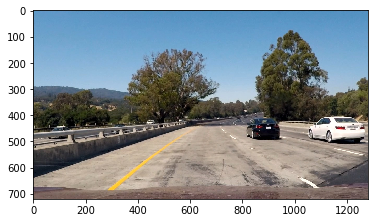

In [133]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

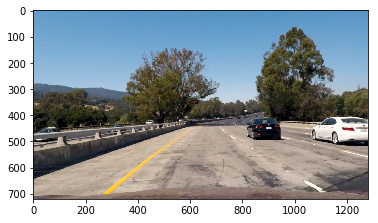

In [134]:
plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))

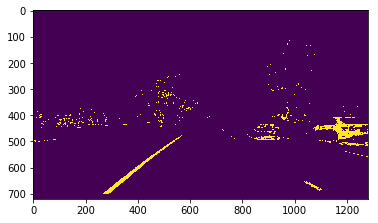

In [135]:
# Edit this function to create your own pipeline.
def get_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    combined = np.zeros_like(sxbinary)
    combined[((s_binary == 1) | (sxbinary == 1))] = 1

    return s_binary
    
binary = get_binary(undist)
plt.imshow(binary)


In [136]:
top=image.shape[0]*0.65
left = image.shape[1]*.45
right = image.shape[1]*.55
vertices = np.array([[(0,image.shape[0]),(left, top), (right, top), (image.shape[1],image.shape[0])]], dtype=np.int32)

In [81]:
vertices

array([[[   0,  720],
        [ 576,  468],
        [ 704,  468],
        [1280,  720]]])

In [137]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 1)
    
    #returning the image only where mask pixels are nonzero
    cropped = np.zeros_like(img)
    cropped[((img == 1) & (mask == 1))] = 1

    return cropped

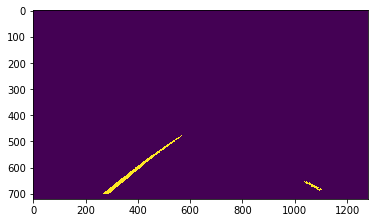

In [138]:
masked = region_of_interest(binary, vertices)
plt.imshow(masked)

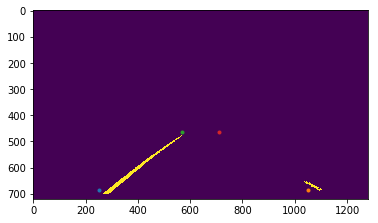

In [139]:
plt.imshow(masked)
plt.plot(250,684,'.')
plt.plot(1050,684,'.')
plt.plot(570,463,'.')
plt.plot(710,463,'.')

In [140]:
offset = 100 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

corners = [[570,463],
           [710,463],
           [1050,684],
           [250,684]]
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                [img_size[0]-offset, img_size[1]-offset], 
                [offset, img_size[1]-offset]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
binary_warped = cv2.warpPerspective(masked, M, img_size)

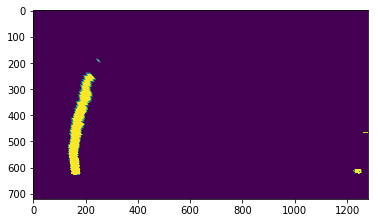

In [141]:
plt.imshow(binary_warped)

In [103]:
binary_warped.shape

(720, 1280)

In [142]:
def get_color_warp(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50
# Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

# Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    return color_warp
    


In [ ]:
def process_image(image):
    
    mtx = np.array([[1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
                 [0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
                 [0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
    dist = np.array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
                    -1.28318543e-04,   2.67124302e-02]])
    top=image.shape[0]*0.65
    left = image.shape[1]*.45
    right = image.shape[1]*.55
    vertices = np.array([[(0,image.shape[0]),(left, top), (right, top), (image.shape[1],image.shape[0])]], dtype=np.int32)
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = get_binary(undist)
    masked = region_of_interest(binary, vertices)
    
    offset = 100 
    img_size = (gray.shape[1], gray.shape[0])

    corners = [[570,463],
               [710,463],
               [1050,684],
               [250,684]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])        
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]-offset], 
                    [offset, img_size[1]-offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    binary_warped = cv2.warpPerspective(masked, M, img_size)
    color_warp = get_color_warp(binary_warped)
    color_unwarp = cv2.warpPerspective(color_warp, Minv, img_size)
    result = cv2.addWeighted(undist, 1, color_unwarp, 0.3, 0)
    
    return result

In [ ]:
color_unwarp = cv2.warpPerspective(color_warp, Minv, img_size)
    # Combine the result with the original image
result = cv2.addWeighted(undist, 1, color_unwarp, 0.3, 0)

(720, 0)

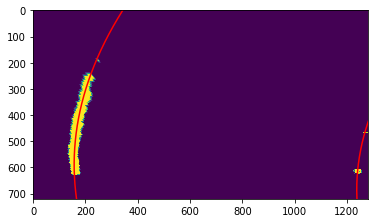

In [143]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(binary_warped)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [144]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

In [148]:
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       ..., 
       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,

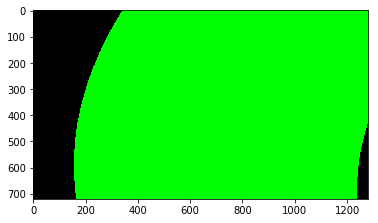

In [149]:
plt.imshow(color_warp)

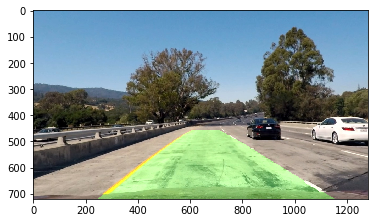

In [151]:
color_unwarp = cv2.warpPerspective(color_warp, Minv, img_size)
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, color_unwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))